Training data dimensions: (60000, 28, 28)


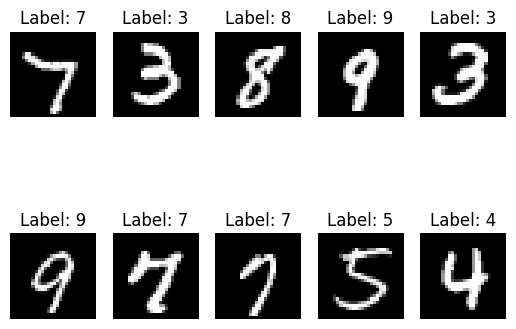

Epoch 1/15
938/938 [==============================] - 72s 75ms/step - loss: 0.1645 - accuracy: 0.9496
Epoch 2/15
938/938 [==============================] - 69s 73ms/step - loss: 0.0472 - accuracy: 0.9854
Epoch 3/15
938/938 [==============================] - 70s 75ms/step - loss: 0.0321 - accuracy: 0.9896
Epoch 4/15
938/938 [==============================] - 68s 73ms/step - loss: 0.0252 - accuracy: 0.9917
Epoch 5/15
938/938 [==============================] - 68s 72ms/step - loss: 0.0203 - accuracy: 0.9936
Epoch 6/15
938/938 [==============================] - 68s 73ms/step - loss: 0.0156 - accuracy: 0.9951
Epoch 7/15
938/938 [==============================] - 68s 73ms/step - loss: 0.0126 - accuracy: 0.9959
Epoch 8/15
938/938 [==============================] - 68s 73ms/step - loss: 0.0106 - accuracy: 0.9967
Epoch 9/15
938/938 [==============================] - 68s 73ms/step - loss: 0.0100 - accuracy: 0.9967
Epoch 10/15
938/938 [==============================] - 70s 75ms/step - loss: 0.009

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

np.random.seed(42)
np.random.shuffle(x_train)
np.random.seed(42)
np.random.shuffle(y_train)
print("Training data dimensions:", x_train.shape)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

x_train = x_train.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, 10)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=15, batch_size=64)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 64)         

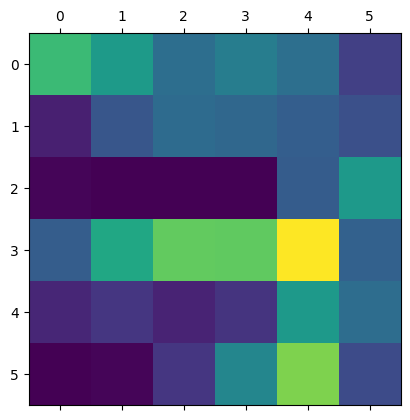

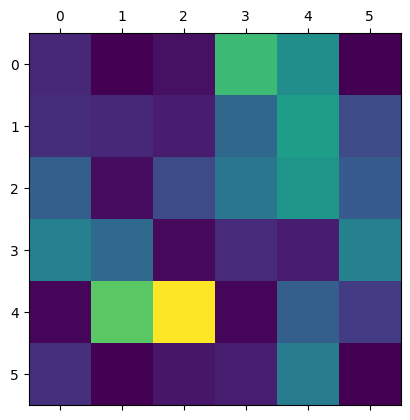

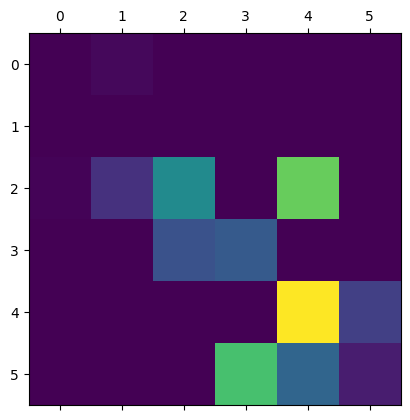

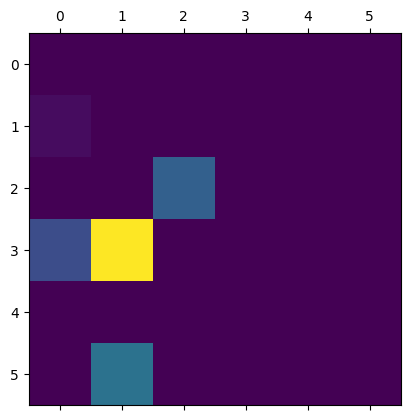

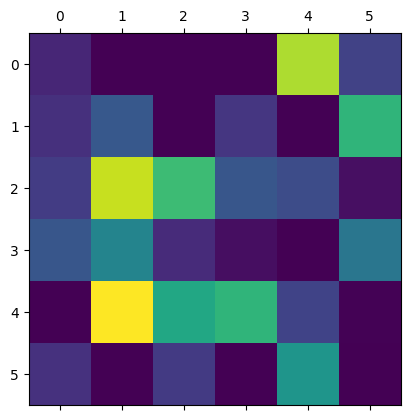

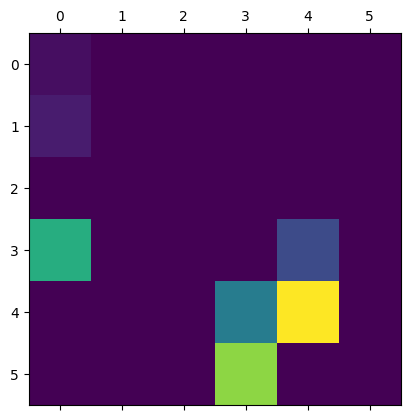

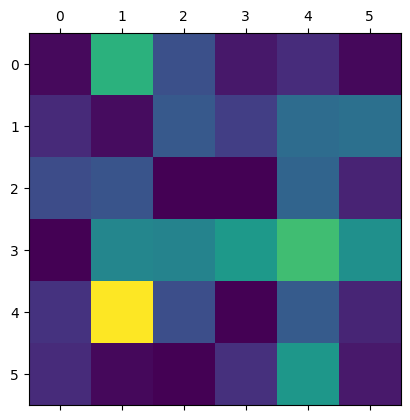

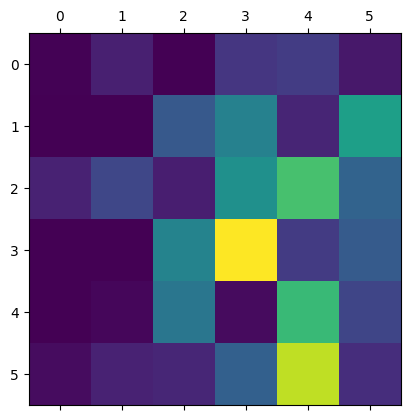

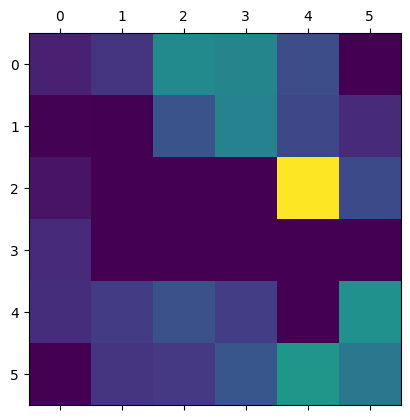

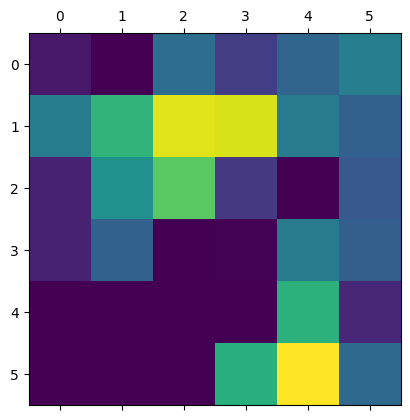

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

sample_images = x_train[:10]
sample_images = np.expand_dims(sample_images, axis=-1)
model.layers[-1].activation = None
model.summary()

last_conv_layer_name = "conv2d_8"

for i in range(10):
    img_array = np.expand_dims(sample_images[i], axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    plt.matshow(heatmap)
    plt.show()
